In [2]:
from spice.models import IcosphereModel
from spice.models.spots import add_spherical_harmonic_spot, add_spherical_harmonic_spots
import jax.numpy as jnp
from spice.plots.plot_mesh import plot_3D
import numpy as np
from transformer_payne import Blackbody
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


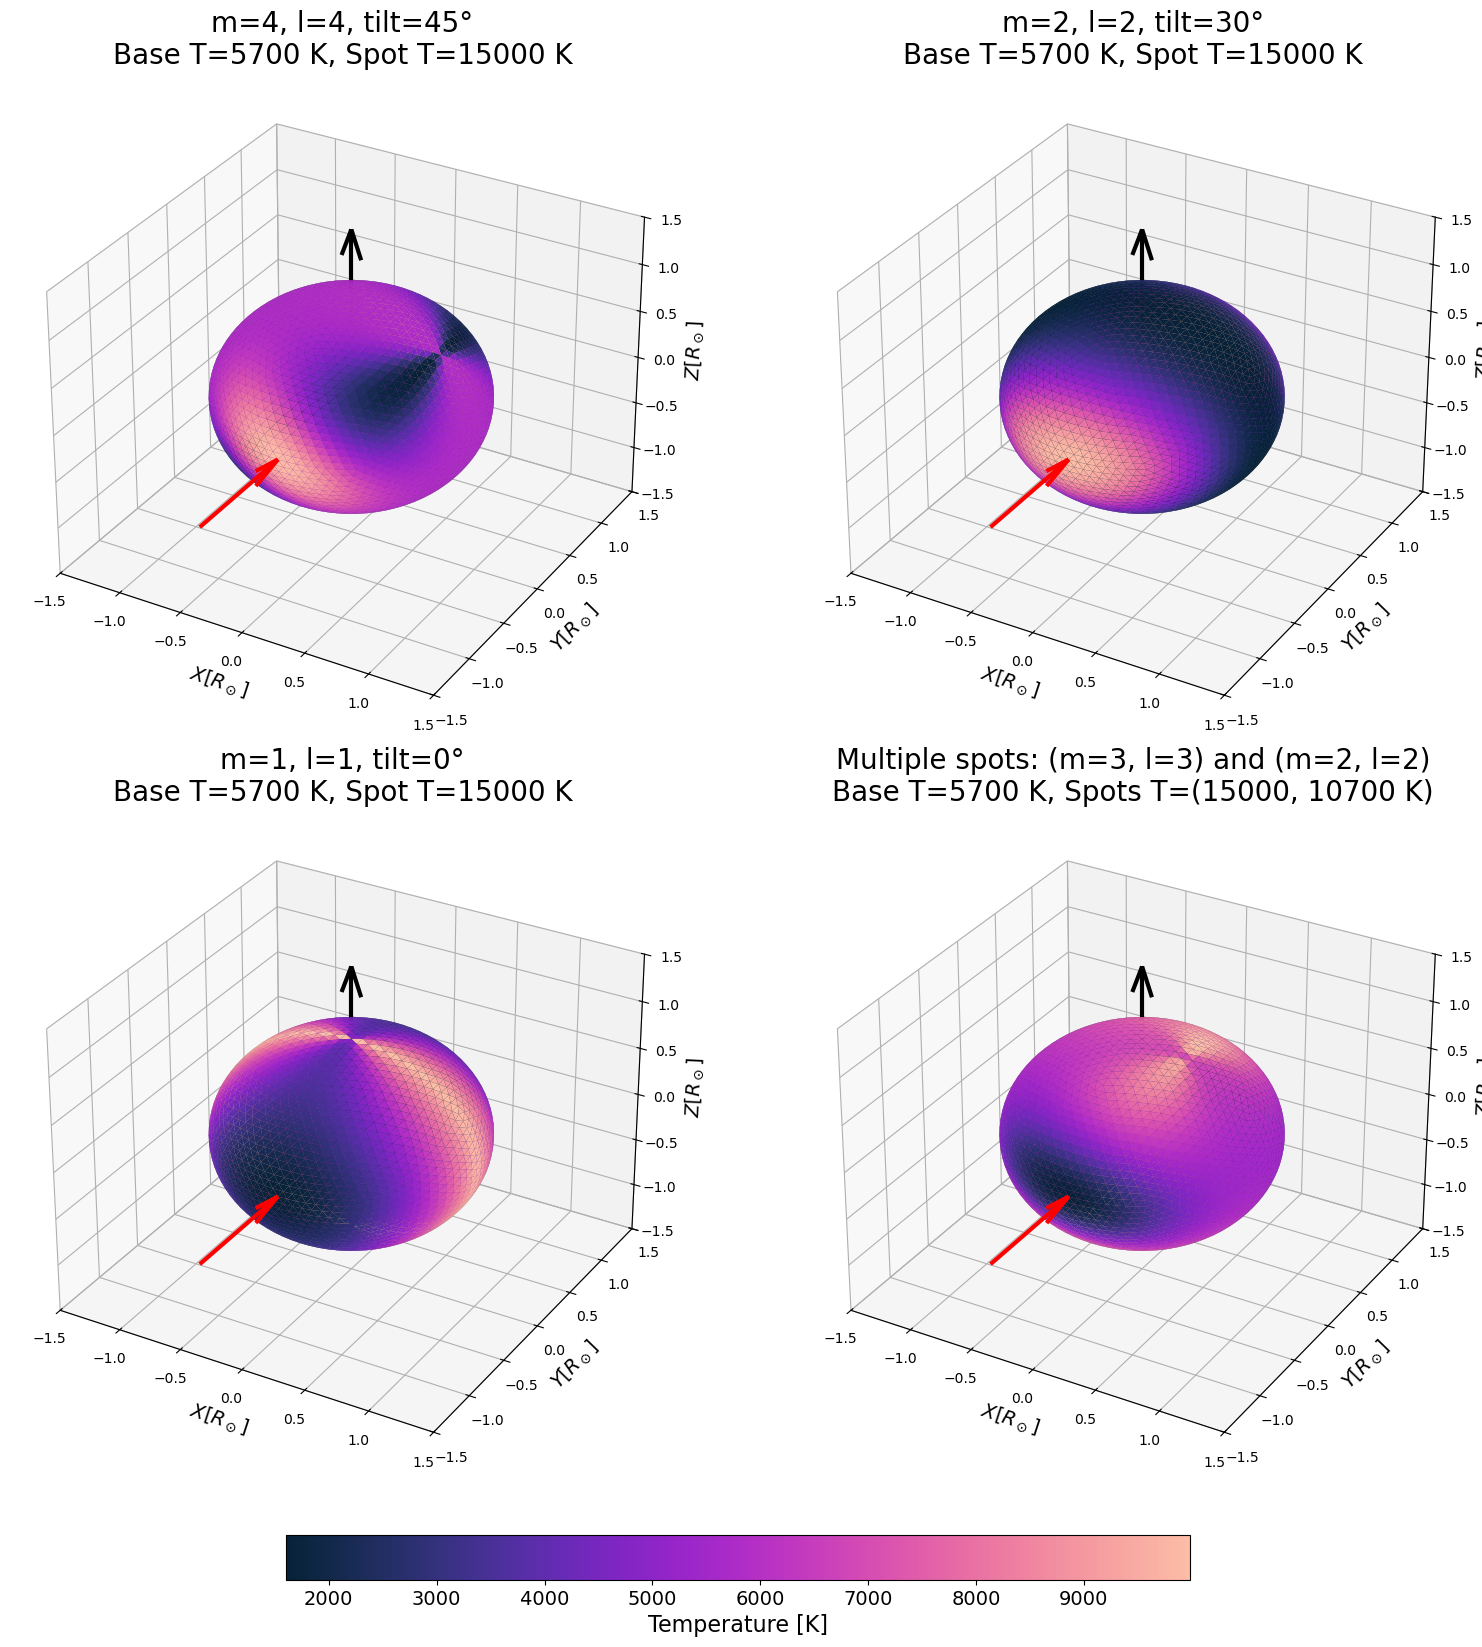

In [34]:
base_temp = 5700
spot_temp = 15000
bb = Blackbody()

# Create base model
m = IcosphereModel.construct(
    5000, 1., 1., bb.to_parameters(dict(teff=base_temp)), bb.parameter_names
)

# Create spotted models
m_spotted1 = add_spherical_harmonic_spot(
    m, 4, 4, param_delta=9300, param_index=0,
    tilt_axis=jnp.array([0., 1., 0.]), tilt_angle=45.
)
m_spotted2 = add_spherical_harmonic_spot(
    m, 2, 2, param_delta=9300, param_index=0,
    tilt_axis=jnp.array([0., 1., 0.])
)
m_spotted3 = add_spherical_harmonic_spot(
    m, 1, 1, param_delta=9300, param_index=0,
    tilt_axis=jnp.array([0., 1., 0.]), tilt_angle=0.
)
m_spotted4 = add_spherical_harmonic_spots(
    m,
    [3, 2], [3, 2],
    param_deltas=[9300, 5000],
    param_indices=[0, 0],
    tilt_axes=jnp.array([
        jnp.array([0., 1., 0.]),
        jnp.array([1., 0., 0.])
    ]),
    tilt_angles=jnp.array([20., 70.])
)

# Compute min/max for temperature over all panels for global normalization
props = [
    np.asarray(m_spotted1.parameters[:, 0]),
    np.asarray(m_spotted2.parameters[:, 0]),
    np.asarray(m_spotted3.parameters[:, 0]),
    np.asarray(m_spotted4.parameters[:, 0]),
]
all_props = np.concatenate(props)
vmin = float(np.min(all_props))
vmax = float(np.max(all_props))

# Set up normalization and colormap for all panels
from matplotlib.colors import Normalize
import cmasher as cmr

norm = Normalize(vmin=vmin, vmax=vmax)
cmap = 'cmr.bubblegum' if 'cmr.bubblegum' in plt.colormaps() else plt.get_cmap('plasma')

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes = [
    [fig.add_subplot(2, 2, 1, projection='3d'), fig.add_subplot(2, 2, 2, projection='3d')],
    [fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4, projection='3d')]
]

# Prepare titles without mixing f-strings and .format to avoid the SyntaxError
spot_titles = [
    "m=4, l=4, tilt=45°" + "\n" + "Base T={} K, Spot T={} K".format(base_temp, base_temp+9300),
    "m=2, l=2, tilt=30°" + "\n" + "Base T={} K, Spot T={} K".format(base_temp, base_temp+9300),
    "m=1, l=1, tilt=0°" + "\n" + "Base T={} K, Spot T={} K".format(base_temp, base_temp+9300),
    "Multiple spots: (m=3, l=3) and (m=2, l=2)" + "\n" +
    "Base T={} K, Spots T=({}, {} K)".format(base_temp, base_temp+9300, base_temp+5000)
]

# Plot each model using the same vmin, vmax, and colormap normalization
for ax, model, title in zip(
    [axes[0][0], axes[0][1], axes[1][0], axes[1][1]],
    [m_spotted1, m_spotted2, m_spotted3, m_spotted4],
    spot_titles
):
    # Use the plot_3D signature from @plot_mesh.py (109-223) with forced normalization
    fig_ax = plot_3D(
        model, property=0, axes=(fig, ax),
        cmap=cmap, property_label="Temperature [K]", update_colorbar=False
    )
    # Patch the Poly3DCollection colors with a shared normalization and colormap
    if hasattr(ax, 'collections') and ax.collections:
        collection = ax.collections[0]
        vals = np.asarray(model.parameters[:, 0])
        collection.set_facecolor(plt.get_cmap(cmap)(norm(vals)))
    if hasattr(ax, 'legend_') and ax.legend_ is not None:
        ax.legend_.remove()
    # Use mathtext with LaTeX formatting, avoid math_fontfamily (not widely supported)
    ax.set_title(rf"{title}", fontsize=20, math_fontfamily="cm")

plt.tight_layout()

# Add the shared colorbar
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=plt.get_cmap(cmap), norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=[ax for row in axes for ax in row], fraction=0.03, pad=0.04,
    orientation='horizontal'
)
cbar.set_label("Temperature [K]", fontsize=16)
cbar.ax.tick_params(labelsize=14)


In [35]:
fig.savefig('sph_harmonic_spots.png', dpi=300, bbox_inches='tight')

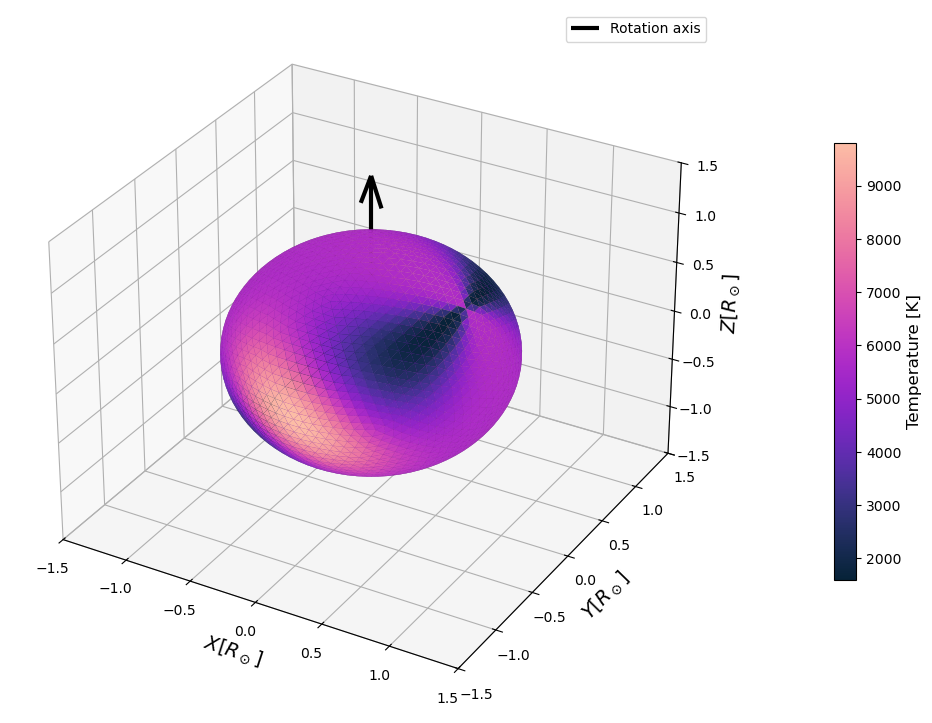

In [63]:
# Configuration 1: m=4, n=4 spot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

m_spotted1 = add_spherical_harmonic_spot(
    m,
    4, # m order
    4, # l degree
    param_delta=9300,
    param_index=0,
    tilt_axis=jnp.array([0., 1., 0.]),
    tilt_angle=45.
)
ax1 = plot_3D(m_spotted1, property=0, axes=(fig, ax), property_label="Temperature [K]", draw_los_vector=False, draw_rotation_axis=True)
plt.tight_layout()

In [64]:
fig.savefig('sph_harmonic_spot.png', dpi=300, bbox_inches='tight')

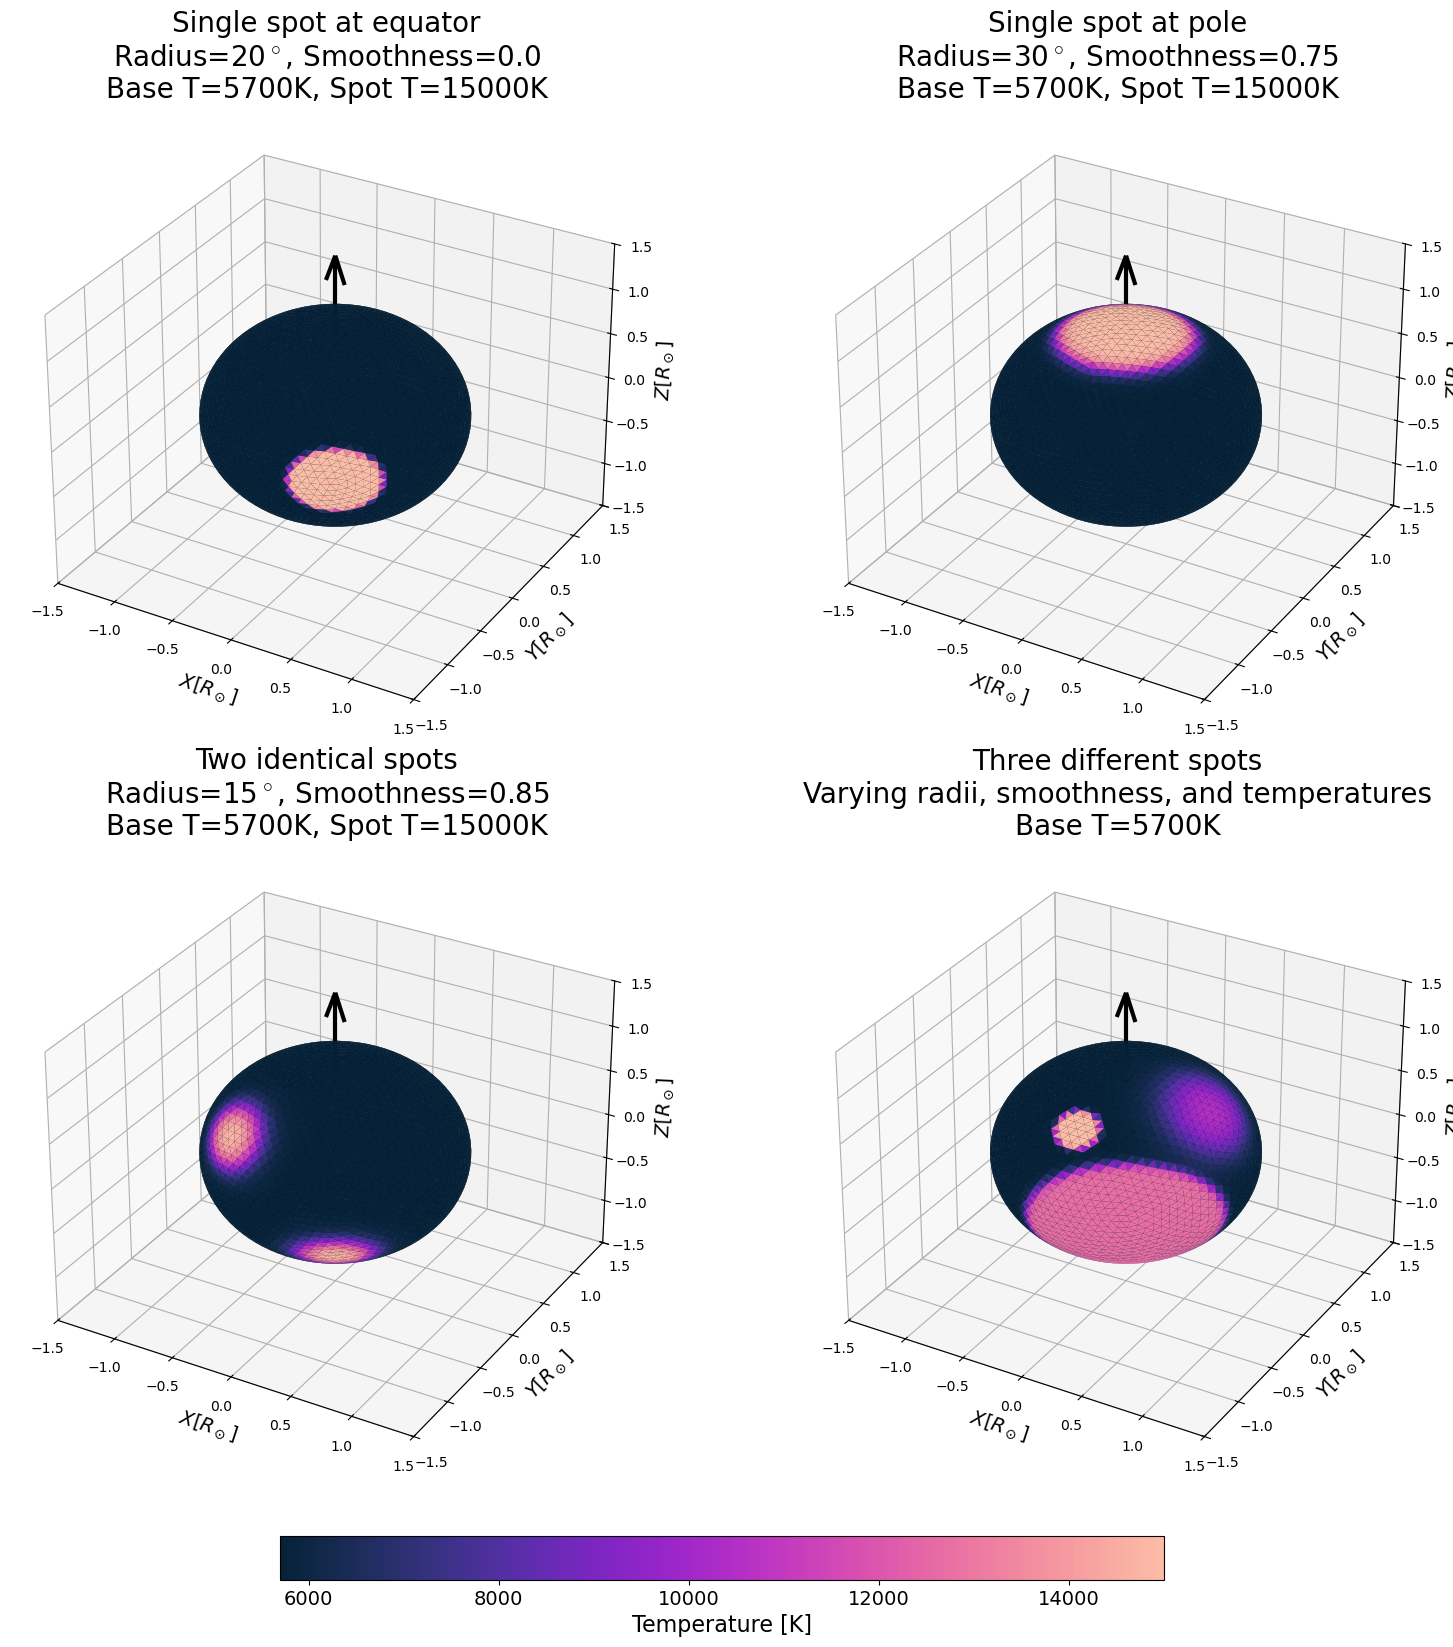

In [ ]:
# For shared color/colormap, directly plot mesh faces here using Poly3DCollection
from spice.models.spots import add_spot, add_spots
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

m_spot1 = add_spot(
    m,
    spot_center_theta=jnp.pi/2,
    spot_center_phi=5*jnp.pi/3,
    spot_radius=20,
    parameter_delta=9300,
    parameter_index=0,
    smoothness=0.0
)
m_spot2 = add_spot(
    m,
    spot_center_theta=0,
    spot_center_phi=0,
    spot_radius=30,
    parameter_delta=9300,
    parameter_index=0,
    smoothness=0.75
)
m_spot3 = add_spots(
    m,
    spot_center_thetas=jnp.array([jnp.pi/3, 2*jnp.pi/3]),
    spot_center_phis=jnp.array([4*jnp.pi/3, 5*jnp.pi/3]),
    spot_radii=jnp.array([15, 15]),
    parameter_deltas=jnp.array([9300, 9300]),
    parameter_indices=jnp.array([0, 0]),
    smoothness=jnp.array([0.85, 0.85])
)
m_spot4 = add_spots(
    m,
    spot_center_thetas=jnp.array([jnp.pi/3-jnp.pi/12, jnp.pi/3-jnp.pi/12, 2*jnp.pi/3-jnp.pi/12]),
    spot_center_phis=jnp.array([4*jnp.pi/3+jnp.pi/6, 4*jnp.pi/3+2*jnp.pi/3, 5*jnp.pi/3]),
    spot_radii=jnp.array([10, 20, 45]),
    parameter_deltas=jnp.array([9300, 5000, 7000]),
    parameter_indices=jnp.array([0, 0, 0]),
    smoothness=jnp.array([0.0, 0.9, 0.5])
)

import numpy as np
vals = [
    np.asarray(m_spot1.parameters[:, 0]),
    np.asarray(m_spot2.parameters[:, 0]),
    np.asarray(m_spot3.parameters[:, 0]),
    np.asarray(m_spot4.parameters[:, 0]),
]
all_vals = np.concatenate(vals)
from matplotlib.colors import Normalize
norm = Normalize(vmin=float(np.min(all_vals)), vmax=float(np.max(all_vals)))
cmap = 'cmr.bubblegum'
colormap = plt.get_cmap(cmap)

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes = [
    [fig.add_subplot(2, 2, 1, projection='3d'), fig.add_subplot(2, 2, 2, projection='3d')],
    [fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4, projection='3d')]
]

spot_titles = [
    r"Single spot at equator" + "\n" +
    r"Radius=20$^\circ$, Smoothness=0.0" + "\n" +
    f"Base T={base_temp}K, Spot T={base_temp+9300}K",
    r"Single spot at pole" + "\n" +
    r"Radius=30$^\circ$, Smoothness=0.75" + "\n" +
    f"Base T={base_temp}K, Spot T={base_temp+9300}K",
    r"Two identical spots" + "\n" +
    r"Radius=15$^\circ$, Smoothness=0.85" + "\n" +
    f"Base T={base_temp}K, Spot T={base_temp+9300}K",
    r"Three different spots" + "\n" +
    r"Varying radii, smoothness, and temperatures" + "\n" +
    f"Base T={base_temp}K"
]

models = [m_spot1, m_spot2, m_spot3, m_spot4]
for ax, model, title in zip([axes[0][0], axes[0][1], axes[1][0], axes[1][1]], models, spot_titles):
    mesh = model
    property_values = np.asarray(mesh.parameters[:, 0])
    vs2 = mesh.mesh_elements
    # Map property values to face colors (inferno, normalized global to all panels)
    face_colors = colormap(norm(property_values))
    poly = Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black", linewidths=0.01)
    ax.add_collection(poly)
    # Center and scale axes
    axes_lim = 1.5 * mesh.radius
    ax.set_xlim3d(-axes_lim, axes_lim)
    ax.set_ylim3d(-axes_lim, axes_lim)
    ax.set_zlim3d(-axes_lim, axes_lim)
    ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
    ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
    ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
    # Draw rotation axis for visibility
    normalized_rotation_axis = mesh.rotation_axis / np.linalg.norm(mesh.rotation_axis)
    ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
              color='black', linewidth=3., label='Rotation axis')
    if hasattr(ax, 'legend_') and ax.legend_ is not None:
        ax.legend_.remove()
    ax.set_title(rf"{title}", fontsize=20, math_fontfamily="cm")

plt.tight_layout()

from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=[ax for row in axes for ax in row], fraction=0.03, pad=0.04,
    orientation='horizontal'
)
cbar.set_label("Temperature [K]", fontsize=16)
cbar.ax.tick_params(labelsize=14)


In [43]:
fig.savefig('spot_examples.png', dpi=300, bbox_inches='tight')

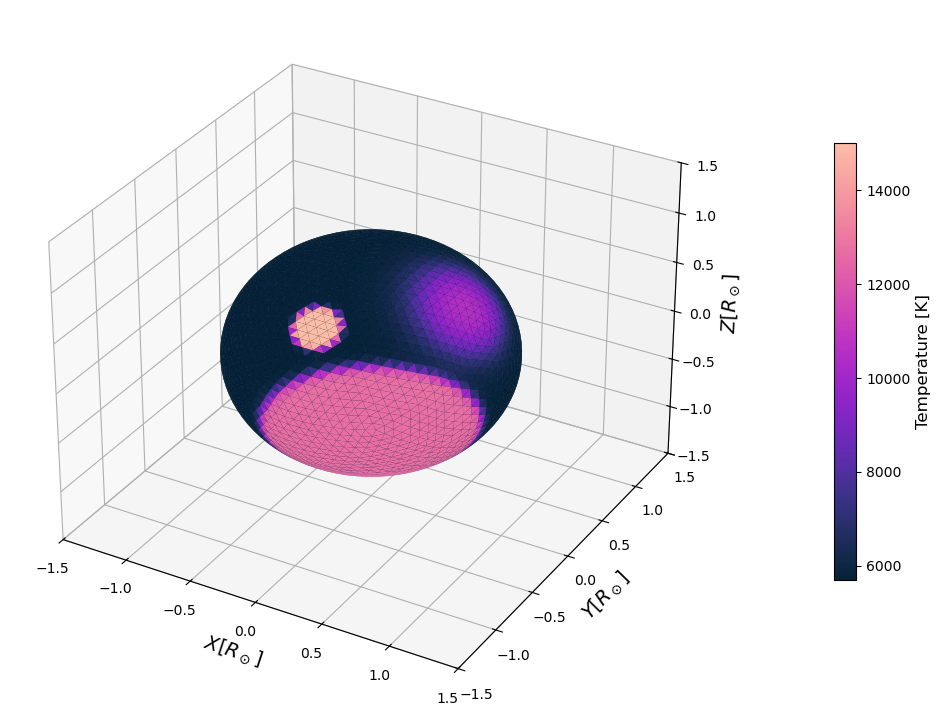

In [44]:
# Configuration 4: Multiple spots with different parameters
m_spot4 = add_spots(
    m,
    spot_center_thetas=jnp.array([jnp.pi/3-jnp.pi/12, jnp.pi/3-jnp.pi/12, 2*jnp.pi/3-jnp.pi/12]),
    spot_center_phis=jnp.array([4*jnp.pi/3+jnp.pi/6, 4*jnp.pi/3+2*jnp.pi/3, 5*jnp.pi/3]),
    spot_radii=jnp.array([10, 20, 45]),                                # Different radii
    parameter_deltas=jnp.array([9300, 5000, 7000]),                    # Different temperature deltas
    parameter_indices=jnp.array([0, 0, 0]),
    smoothness=jnp.array([0.0, 0.9, 0.5])                              # Different smoothness values
)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': '3d'})
ax = plot_3D(m_spot4, property=0, axes=(fig, ax), property_label="Temperature [K]", draw_los_vector=False, draw_rotation_axis=False)
plt.tight_layout()

In [59]:
fig.savefig('spots_example.png', dpi=300, bbox_inches='tight')

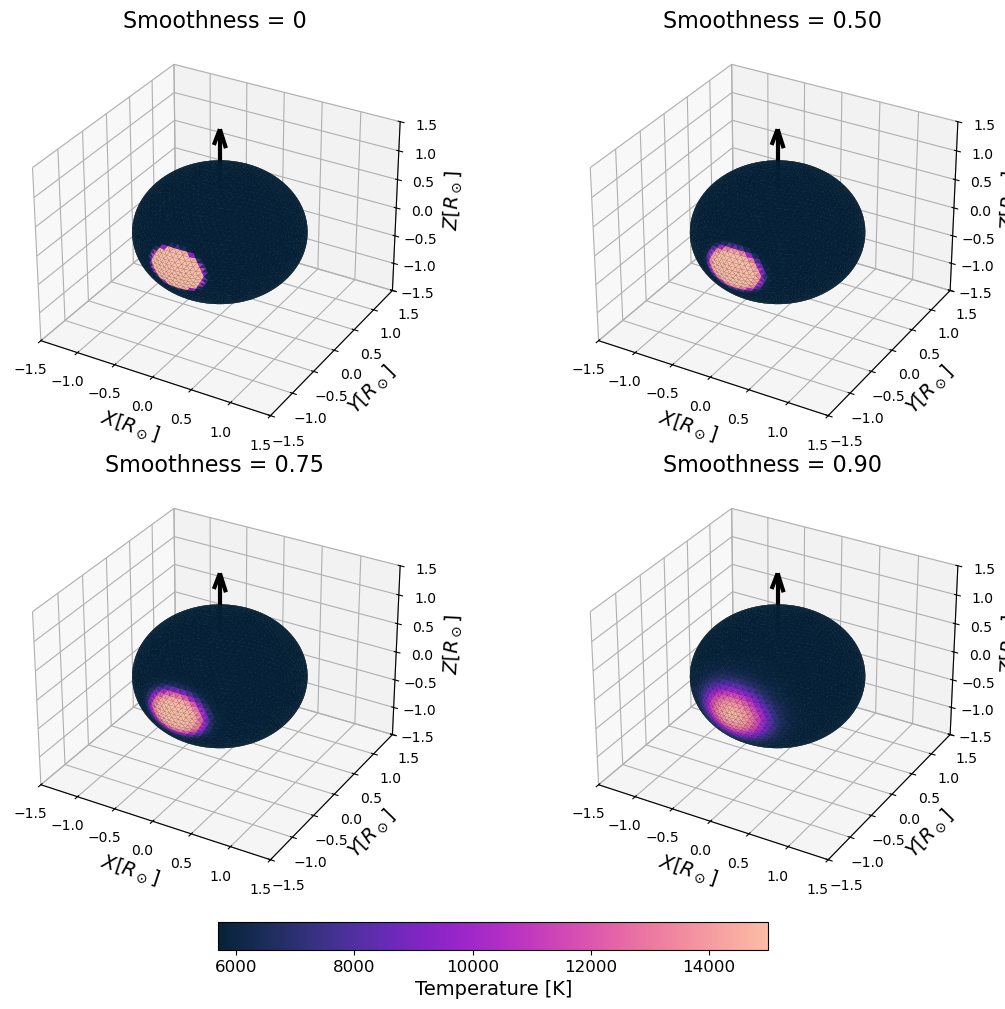

In [56]:
# Plot like first big panel in the notebook for the smoothness series, using direct Poly3DCollection and global color normalization
import numpy as np
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable

base_temp = 5700  # K

# Smoothness to show
smoothness_values = [0.0, 0.5, 0.75, 0.9]
spot_models = [
    add_spot(
        m,
        spot_center_theta=jnp.pi/2,       # equator
        spot_center_phi=3*jnp.pi/2,       # prime meridian
        spot_radius=20,                   # 20 degrees
        parameter_delta=9300,             # temperature difference
        parameter_index=0,                # temperature parameter
        smoothness=smoothness             # varying smoothness
    )
    for smoothness in smoothness_values
]

spot_titles = [
    r"Smoothness = 0", r"Smoothness = 0.50", r"Smoothness = 0.75", r"Smoothness = 0.90"
]

vals = [np.asarray(model.parameters[:, 0]) for model in spot_models]
all_vals = np.concatenate(vals)
norm = Normalize(vmin=float(np.min(all_vals)), vmax=float(np.max(all_vals)))
cmap = 'cmr.bubblegum'
colormap = plt.get_cmap(cmap)

fig2 = plt.figure(figsize=(12, 10))
fig2.subplots_adjust(hspace=0.3, wspace=0.3)
axes2 = [
    fig2.add_subplot(2, 2, 1, projection='3d'),
    fig2.add_subplot(2, 2, 2, projection='3d'),
    fig2.add_subplot(2, 2, 3, projection='3d'),
    fig2.add_subplot(2, 2, 4, projection='3d'),
]

for ax, model, title, smoothness in zip(axes2, spot_models, spot_titles, smoothness_values):
    mesh = model
    property_values = np.asarray(mesh.parameters[:, 0])
    vs2 = mesh.mesh_elements
    face_colors = colormap(norm(property_values))
    poly = Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black", linewidths=0.01)
    ax.add_collection(poly)
    axes_lim = 1.5 * mesh.radius
    ax.set_xlim3d(-axes_lim, axes_lim)
    ax.set_ylim3d(-axes_lim, axes_lim)
    ax.set_zlim3d(-axes_lim, axes_lim)
    ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
    ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
    ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
    normalized_rotation_axis = mesh.rotation_axis / np.linalg.norm(mesh.rotation_axis)
    ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
              color='black', linewidth=3., label='Rotation axis')
    if hasattr(ax, 'legend_') and ax.legend_ is not None:
        ax.legend_.remove()
    ax.set_title(rf"{title}", fontsize=16, math_fontfamily="cm", pad=-2)  # reduce pad for smaller space

plt.tight_layout(rect=[0, 0, 1, 0.97])   # adjust rect so the tight layout does not put too much space above

sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig2.colorbar(
    sm,
    ax=axes2, fraction=0.03, pad=0.04,
    orientation='horizontal'
)
cbar.set_label("Temperature [K]", fontsize=14)
cbar.ax.tick_params(labelsize=12)


In [62]:
fig2.savefig('spot_smoothness_effect.png', dpi=300, bbox_inches='tight')

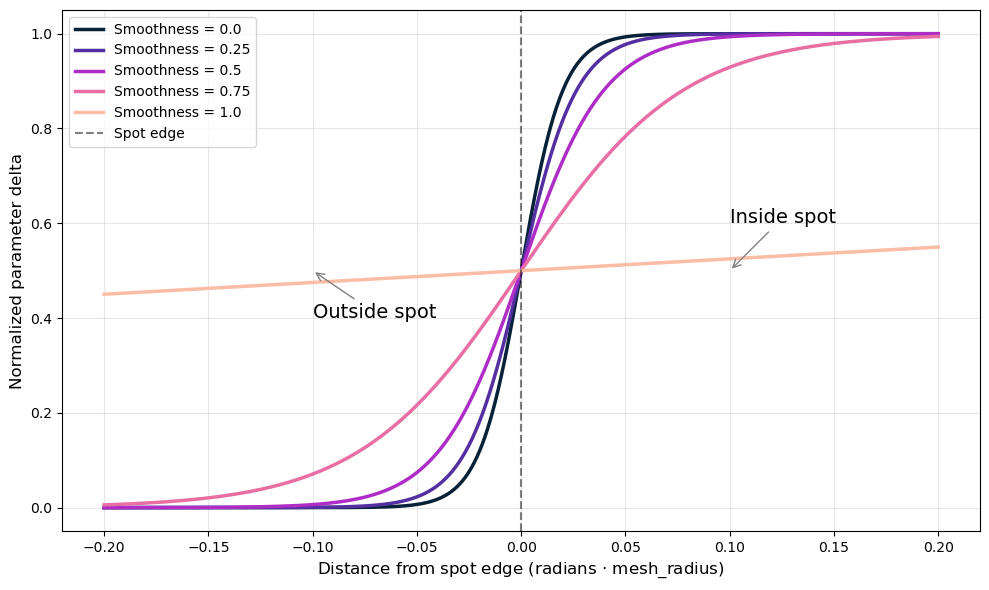

In [60]:
import cmasher as cmr

# Create a figure to demonstrate how parameter_delta varies with distance from spot edge
# for different smoothness values
fig3, ax3 = plt.subplots(figsize=(10, 6))

# Define a range of distances from the spot edge (negative = outside, positive = inside)
distances = np.linspace(-0.2, 0.2, 1000)  # in radians * mesh_radius

# Define the smoothness values to plot
smoothness_values = [0.0, 0.25, 0.5, 0.75, 1.0]
colors = cmr.bubblegum(np.linspace(0, 1, len(smoothness_values)))

# Set parameter difference
parameter_diff = 1.0  # normalized to 1.0 for visualization

for i, smoothness in enumerate(smoothness_values):
    # Calculate the normalized distances (using same scale factor as in spots.py)
    scale_factor = 0.01  # simplified from the original code
    normalized_distances = np.clip(distances / scale_factor, -100.0, 100.0)
    
    # Calculate adjusted smoothness (as in spots.py)
    adjusted_smoothness = (1.0 - smoothness) + 0.01 * smoothness
    
    # Calculate the parameter delta using sigmoid function
    parameter_deltas = 1 / (1 + np.exp(-normalized_distances * adjusted_smoothness))
    
    # Plot the result
    ax3.plot(distances, parameter_deltas, label=f"Smoothness = {smoothness}", 
             color=colors[i], linewidth=2.5)

# Add vertical line at spot edge
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5, label="Spot edge")

# Add labels and legend
ax3.set_xlabel("Distance from spot edge (radians $\cdot$ mesh_radius)", fontsize=12)
ax3.set_ylabel("Normalized parameter delta", fontsize=12)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Add annotations
ax3.annotate("Inside spot", xy=(0.1, 0.5), xytext=(0.1, 0.6),
             arrowprops=dict(arrowstyle="->", color="gray"), fontsize=14)
ax3.annotate("Outside spot", xy=(-0.1, 0.5), xytext=(-0.1, 0.4),
             arrowprops=dict(arrowstyle="->", color="gray"), fontsize=14)

plt.tight_layout()


In [61]:
fig3.savefig('smoothness.png', dpi=300, bbox_inches='tight')